考虑大模型介入可能性，很有机会-louis

# import

In [1]:
import copy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.affinity import affine_transform
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon, box
from geopandas import GeoSeries, GeoDataFrame
from shapely.ops import split, unary_union, polygonize
import pickle

# Config

In [2]:
NON_BLOCK_LAND_USE = (
    'outside',
    'feasible',
    'road',
    'boundary'
)

BLOCK_LAND_USE = (
    'residential',
    'business',
    'office',
    'green_l',
    'green_s',
    'school',
    'hospital_l',
    'hospital_s',
    'recreation'
)

LAND_USE = (
    NON_BLOCK_LAND_USE + BLOCK_LAND_USE)

OUTSIDE = 0
FEASIBLE = 1
ROAD = 2
BOUNDARY = 3
RESIDENTIAL = 4
BUSINESS = 5
OFFICE = 6
GREEN_L = 7
GREEN_S = 8
SCHOOL = 9
HOSPITAL_L = 10
HOSPITAL_S = 11
RECREATION = 12

LAND_USE_ID = (
    OUTSIDE,
    FEASIBLE,
    ROAD,
    BOUNDARY,
    RESIDENTIAL,
    BUSINESS,
    OFFICE,
    GREEN_L,
    GREEN_S,
    SCHOOL,
    HOSPITAL_L,
    HOSPITAL_S,
    RECREATION
)

NUM_TYPES = len(LAND_USE_ID)

LAND_USE_ID_MAP = dict(
    zip(LAND_USE, LAND_USE_ID))

LAND_USE_ID_MAP_INV = dict(
    zip(LAND_USE_ID, LAND_USE))

INTERSECTION = 13

# read data

In [3]:
gdf_land = gpd.read_file('land.shp')
gdf_land.crs = None
gdf_main_road = gpd.read_file('mainroad.shp')
gdf_main_road.crs = None
gdf_road = gpd.read_file('line.shp')
gdf_road.crs = None


gdf_main_road['type'] = 'main_road'
gdf_road['type'] = 'road'
gdf_combined = pd.concat([gdf_main_road, gdf_road])

# translate, rescale, obtain intersections

In [4]:
def translate_and_rescale(gdf):
    # Get the minimum x and y values from total_bounds
    x_min, y_min, x_max, y_max = gdf.total_bounds
    
    # Calculate the translation values
    x_translation = -x_min
    y_translation = -y_min
    
    # Apply the translation to the GeoDataFrame
    gdf['geometry'] = gdf.translate(xoff=x_translation, yoff=y_translation)
    
    scaling_factor = 0.1  # Scale down by a factor of 10
    
    # Create the scaling matrix
    scaling_matrix = [scaling_factor, 0, 0, scaling_factor, 0, 0]
    
    # Apply the scaling transformation to the GeoDataFrame
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: affine_transform(geom, scaling_matrix))

    return gdf

In [5]:
gdf_land = translate_and_rescale(gdf_land)
gdf_combined = translate_and_rescale(gdf_combined)
gdf_road = gdf_combined[gdf_combined['type']=='road'].copy()
gdf_main_road = gdf_combined[gdf_combined['type']=='main_road'].copy()

In [6]:
def explode_lines(gdf_road):
    # Create or load the GeoDataFrame gdf_road
    # For this example, let's assume you have a GeoDataFrame named gdf_road
    
    # Define a tolerance value for simplification (adjust as needed)
    tolerance = 0.1  # You can adjust this value based on your dataset and needs
    
    # Apply the simplify operation to the 'geometry' column
    gdf_road['geometry'] = gdf_road['geometry'].apply(lambda geom: geom.simplify(tolerance, preserve_topology=True) if geom.geom_type == 'LineString' else geom)
    
    
    # Define a function to extract coordinates from LineString and convert to Points
    def extract_coordinates_to_points(line):
        return [Point(coord) for coord in line.coords]
    
    # Apply the function to create a new 'points' column
    gdf_road['points'] = gdf_road['geometry'].apply(extract_coordinates_to_points)
    
    # Explode the 'points' column to create a new GeoDataFrame with points
    gdf_points = gdf_road.explode('points')
    
    # Merge LineString and Point geometries into a single 'geometry' column
    gdf_points['geometry'] = gdf_points['points']
    gdf_points = gdf_points.drop('points', axis=1)
    
    # Create a set to store unique integer nodes
    unique_nodes = set()
    
    # Function to approximate coordinates of a point to integers
    def approximate_to_integers(point):
        return Point(int(point.x), int(point.y))
    
    # Iterate through the 'geometry' column and add unique integer nodes to the set
    for geom in gdf_points['geometry']:
        if geom.geom_type == 'Point':
            integer_node = approximate_to_integers(geom)
            unique_nodes.add(integer_node)
    
    # Create a GeoDataFrame from the set of unique integer nodes
    simplified_gdf_points = gpd.GeoDataFrame(geometry=list(unique_nodes), crs=gdf_points.crs)
    
    gdf_road = gdf_road.drop('points', axis=1)
    
    # Combine the original GeoDataFrame 'gdf_road' with 'gdf_points'
    gdf = pd.concat([gdf_road, simplified_gdf_points], ignore_index=True)
    
    # Now, add the 'x' and 'y' columns
    gdf['x'] = gdf['geometry'].apply(lambda geom: geom.x if geom.geom_type == 'Point' else None)
    gdf['y'] = gdf['geometry'].apply(lambda geom: geom.y if geom.geom_type == 'Point' else None)
    return gdf

In [7]:
gdf_main_road_exploded = explode_lines(gdf_main_road)
gdf_road_exploded = explode_lines(gdf_road)
gdf_main_road_exploded['type'] = 'main_road'
gdf_road_exploded['type'] = 'road'
gdf_combined = pd.concat([gdf_main_road_exploded, gdf_road_exploded])

# visualization

## plot_gdf

In [8]:
def plot_gdf(gdf, filename=None, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    gdf.plot(ax=ax, linewidth=2, markersize=15, **kwargs)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

## reference

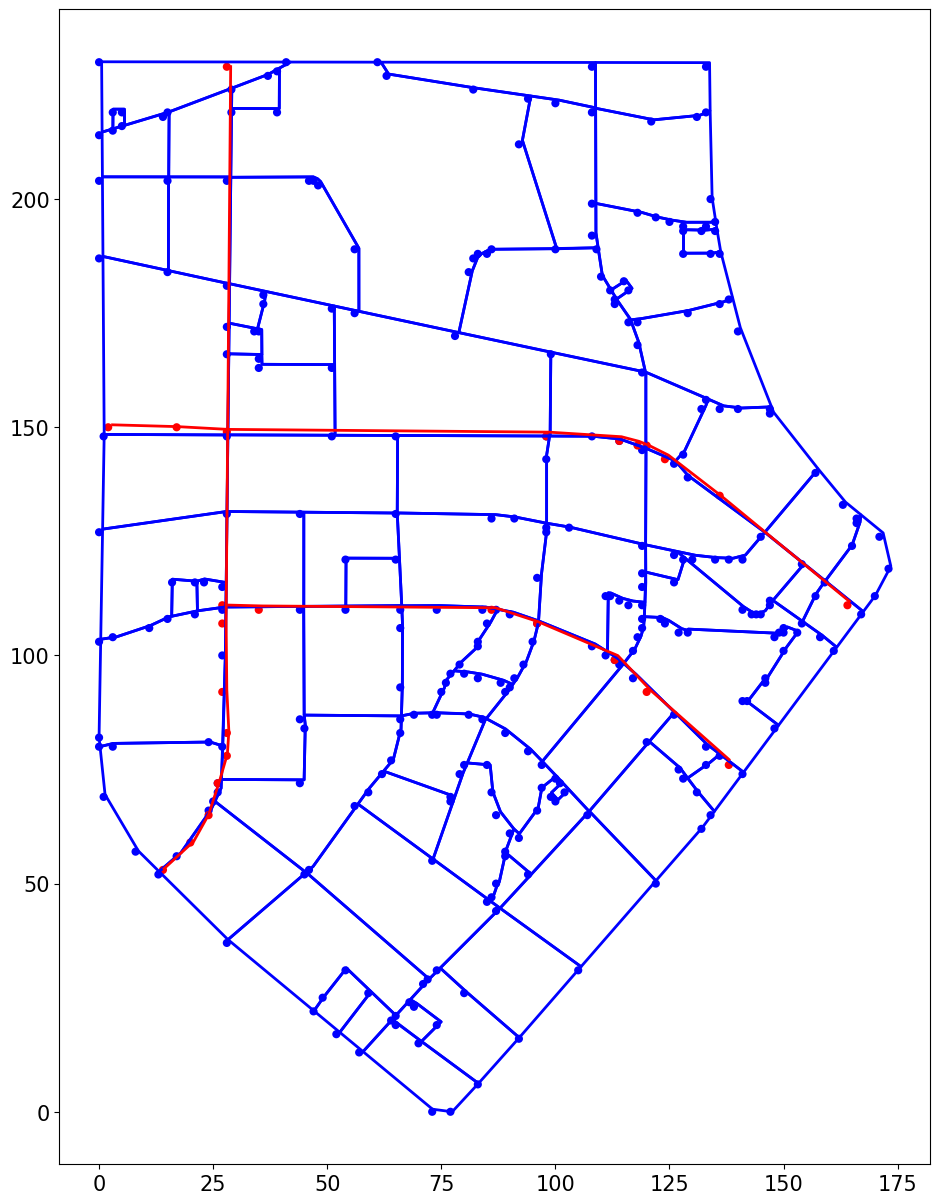

In [9]:
color_dict = {
    'main_road': 'red',
    'road': 'blue'
}
gdf_combined = gdf_combined.sort_values(by='type', ascending=False)
plot_gdf(gdf_combined, color=gdf_combined['type'].apply(lambda x: color_dict[x]), categorical=True, k=2, filename='roads.pdf')

In [10]:
# Use the .explore() method to visualize the GeoDataFrame with colors based on the 'type' column
gdf_combined = gdf_combined.sort_values(by='type', ascending=False)
gdf_combined.explore(column='type', cmap=['red', 'blue'], categorical=True, k=2)

# generate initial plan

## annotate the map manually


<div style="display: flex; justify-content: center;">
    <img src="roads_annotated_v2.jpeg" width="45%" style="margin-right: 5px;">
    <img src="roads_simplified_v2.jpeg" width="45%">
</div)

## obtain simplified road segments

In [11]:
# # # roads as reference 'huizhou'
# roads = [
#     LineString([(0, 230), (0, 86), (13, 52)]), # 银湖路
#     LineString([(13, 52), (28, 37), (52, 17), (57, 13), (75, 0)]), # 银岭路
#     LineString([(0, 230), (135, 230)]), # 横一路
#     LineString([(135, 230), (135, 177), (147, 153), (157, 140), (175, 124)]), # 惠河高速公路
#     LineString([(175, 124), (167, 109), (141, 74), (134, 65), (122, 50), (105, 31), (92, 16), (83, 6), (75, 0)]), #仲恺大道
#     LineString([(29, 230), (29, 72), (13, 52)]), # 陈江大道
#     LineString([(0, 148), (120, 148), (147, 127), (167, 109)]), # 五一大道
#     LineString([(0, 127), (128, 127), (147, 127), (157, 140)]), #泄洪渠
#     LineString([(0, 110), (98, 110), (114, 98), (126, 87), (133, 80), (141, 74)]), # 体育路
#     LineString([(0, 86), (84, 86), (97, 76), (107, 65), (122, 50)]), # 胜利路
#     LineString([(0, 204), (50, 204), (50, 176), (50, 148)]), # A
#     LineString([(0, 187), (29, 181), (50, 176), (78, 170), (98, 166), (120, 162), (147, 153)]), # 五一村道
#     LineString([(44, 127), (44, 72), (29, 72)]), # B
#     LineString([(66, 148), (66, 86), (56, 67), (46, 53), (28, 37)]), # C
#     LineString([(98, 166), (98, 110), (84, 86), (73, 55)]), # D
#     LineString([(108, 230), (108, 189), (116, 173), (120, 162), (120, 118), (120, 110), (114, 98), (97, 76)]), # E
#     LineString([(126, 87), (119, 78), (107, 65), (87, 44), (72, 29), (68, 24), (65, 21), (57, 13)]), # F
#     LineString([(94, 217), (94, 189)]), # G
#     LineString([(0, 214), (29, 224), (41, 230)]), # H-1
#     LineString([(61, 230), (94, 217), (135, 217)]), #H-2
#     LineString([(78, 170), (83, 189), (108, 189)]), # I-1
#     LineString([(108, 199), (135, 199)]), #I-2
#     LineString([(116, 173), (135, 177)]), # I-3
#     LineString([(119,78), (128, 73), (134, 65)]), # J
#     LineString([(56, 67), (73, 55), (87, 44), (105, 31)]), # K
#     LineString([(29, 72), (46, 53), (72, 29), (92, 16)]), #L
#     LineString([(52, 17), (59, 26), (65, 21), (70, 15), (83, 6)]), #S3-S4-1
#     LineString([(68, 24), (74, 19), (70, 15)]), #S3-S4-2
#     LineString([(133, 80), (128, 73)]), #S3-S4-3
#     LineString([(120, 118), (128, 118), (128, 127)]), #S3-S4-4
# ]

In [12]:
#manual test,改线试试，修改布局的关键要素！！手动搓线
roads = [
#jinhua
LineString([(0,120),(25,78),(55,0)]),
LineString([(45,139),(63,112),(84,80),(108,31)]),
LineString([(115,171),(135,134),(173,66)]),
LineString([(206,227),(243,145),(263,94)]),
LineString([(264,254),(306,161),(328,112)]),
LineString([(339,276),(381,179),(386,158),(389,126)]),
LineString([(384,280),(456,219)]),
LineString([(436,202),(449,130)]),
LineString([(25,78),(63,112)]),
LineString([(135,134),(216,140),(243,145),(306,161),(381,179),(436,202),(456,219)]),
LineString([(0,120),(45,139),(115,171),(206,227),(264,254),(339,276),(384,280)]),
LineString([(55,0),(108,31),(173,66),(263,94),(328,112),(389,126),(449,130)]),

# #合成的线
# LineString([(124,-144),(159,-144),(194,-144),(229,-144)]),
# LineString([(124,-203),(147,-203),(198,-214),(233,-214)]),
# LineString([(124,-262),(166,-249),(198,-252),(233,-252)]),
# LineString([(124,-322),(159,-322),(198,-322),(233,-322)]),
# LineString([(124,-322),(124,-262),(124,-203),(124,-144)]),
# LineString([(147,-203),(159,-322)]),
# LineString([(194,-144),(198,-214)]),
# LineString([(229,-144),(233,-214)]),
# LineString([(124,-262),(147,-203),(159,-144)]),
# LineString([(124,-262),(166,-249),(198,-214),(229,-144)]),
# LineString([(159,-322),(198,-252),(233,-322)]),
# LineString([(198,-322),(198,-252),(198,-214)]),
# LineString([(233,-322),(233,-252),(233,-214)]),






]

In [13]:
def aggregate(lines):
    line = lines[0]
    for var in range(1, len(lines)):
        line = split(line, lines[var])
        if len(line.geoms) > 1:
            line = MultiLineString(line)
        else:
            line = line.geoms[0]
        new_line = split(lines[var], line)
        if len(new_line.geoms) > 1:
            new_line = MultiLineString(new_line)
        else:
            new_line = new_line.geoms[0]
        line = line.union(new_line)
    temp_roads = list(line.geoms)
    roads = []
    for road in temp_roads:
        if len(road.coords) == 2:
            roads.append(road)
        elif len(road.coords) > 2:
            divided_roads = [LineString([road.coords[i], road.coords[i+1]]) for i in range(len(road.coords) - 1)]
            roads.extend(divided_roads)
        else:
            raise RuntimeError('Number of segments fault!')
    roads_type = [ROAD for _ in range(len(roads))]
    intersections = []
    for road in roads:
        intersections.append(Point(road.coords[0]))
        intersections.append(Point(road.coords[1]))
    intersections = list(unary_union(intersections).geoms)
    intersections_type = [INTERSECTION for _ in range(len(intersections))]
    feasibles = list(polygonize(roads))
    feasibles_type = [FEASIBLE for _ in range(len(feasibles))]
    types = roads_type + intersections_type + feasibles_type
    geometries = roads + intersections + feasibles
    gdf = GeoDataFrame({'id': list(range(len(types))),
                        'type': types,
                        'existence': [True for _ in range(len(types))],
                        'geometry': geometries}).set_index('id')
    return gdf

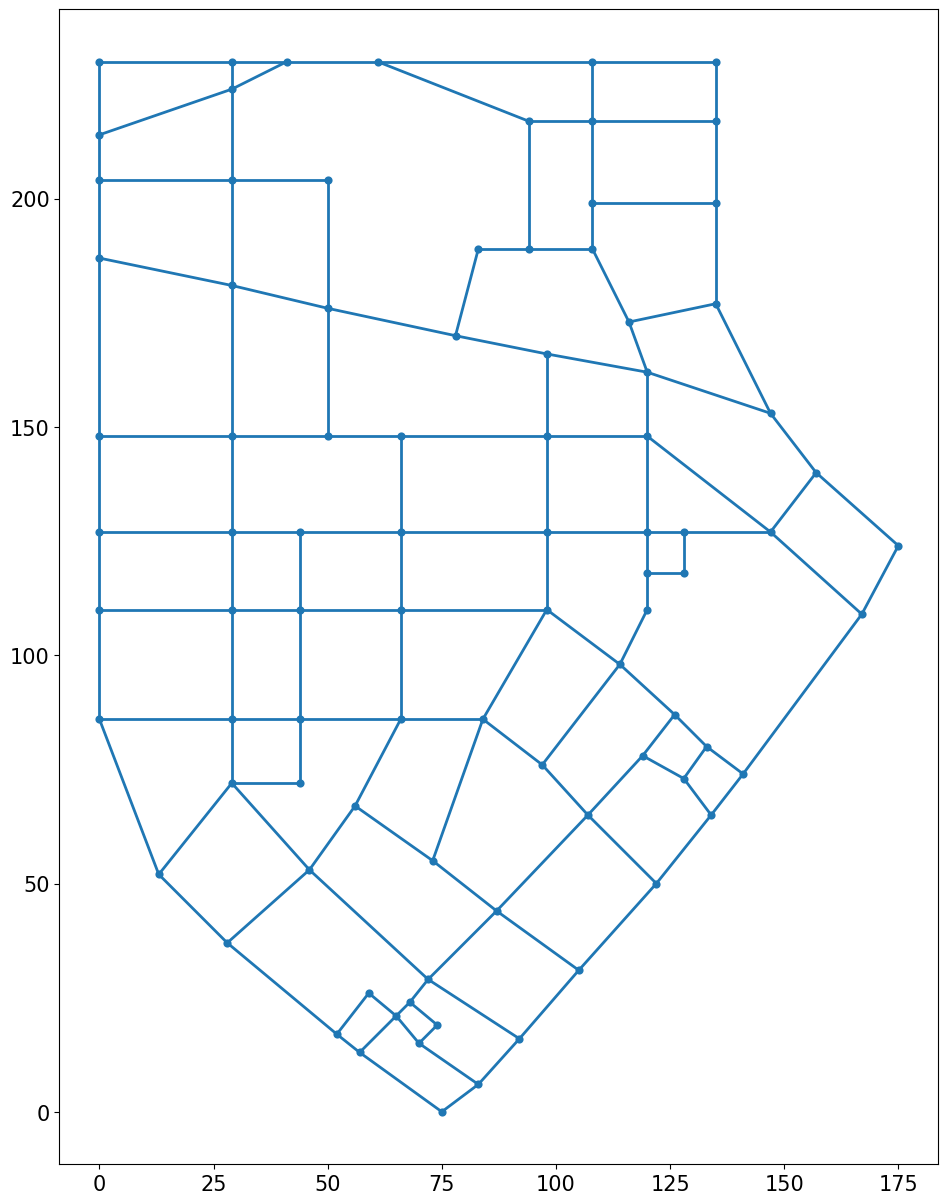

In [42]:
gdf_simplified = aggregate(roads)
plot_gdf(gdf_simplified[gdf_simplified.geom_type!='Polygon'])

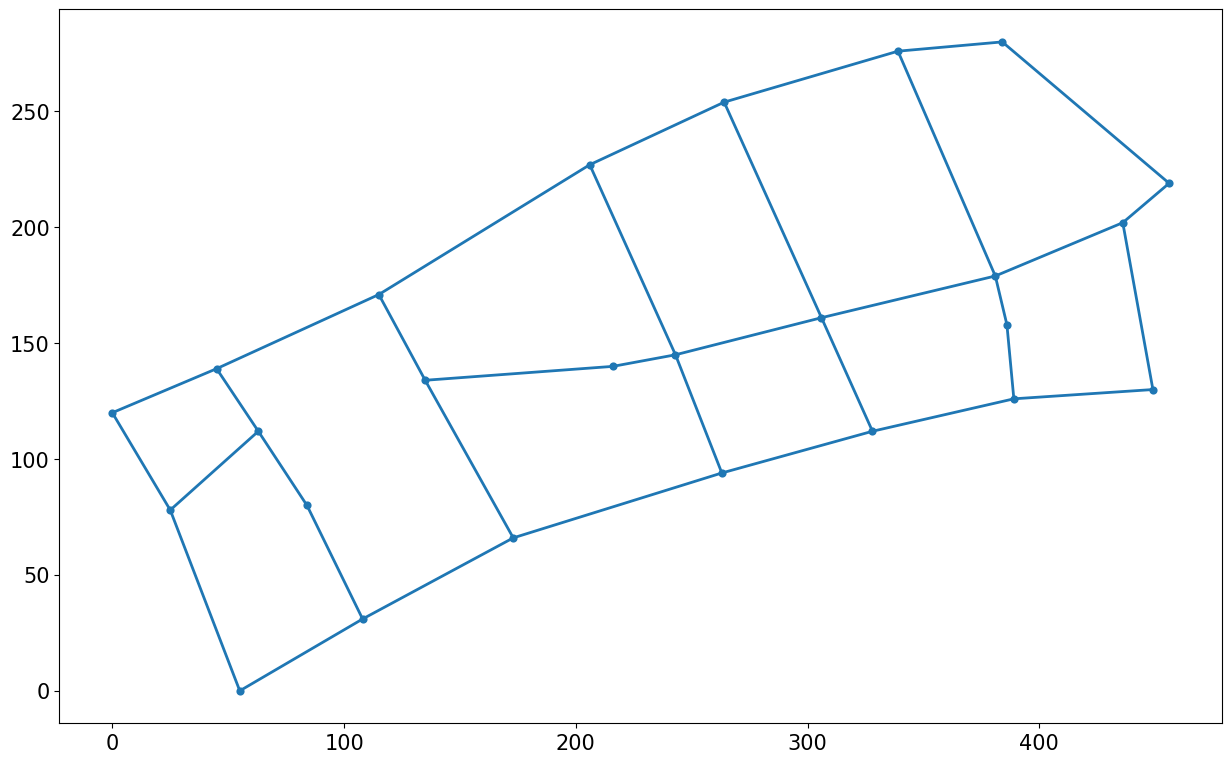

In [14]:
#修改后的road
gdf_simplified = aggregate(roads)
plot_gdf(gdf_simplified[gdf_simplified.geom_type!='Polygon'])

In [33]:
# print(len(gdf_simplified[gdf_simplified.geom_type=='LineString']))
# print(len(gdf_simplified[gdf_simplified.geom_type=='Point']))
# print(len(gdf_simplified[gdf_simplified.geom_type=='Polygon']))

141
88
54


In [15]:
#修改的
print(len(gdf_simplified[gdf_simplified.geom_type=='LineString']))
print(len(gdf_simplified[gdf_simplified.geom_type=='Point']))
print(len(gdf_simplified[gdf_simplified.geom_type=='Polygon']))

25
18
8


In [43]:
gdf_road_simplified = gdf_simplified[gdf_simplified.geom_type!='Polygon']
gdf_road_simplified.explore()

In [49]:
#修改后测试
gdf_road_simplified = gdf_simplified[gdf_simplified.geom_type!='Polygon']
gdf_road_simplified.explore()

## compare simplified and original roads

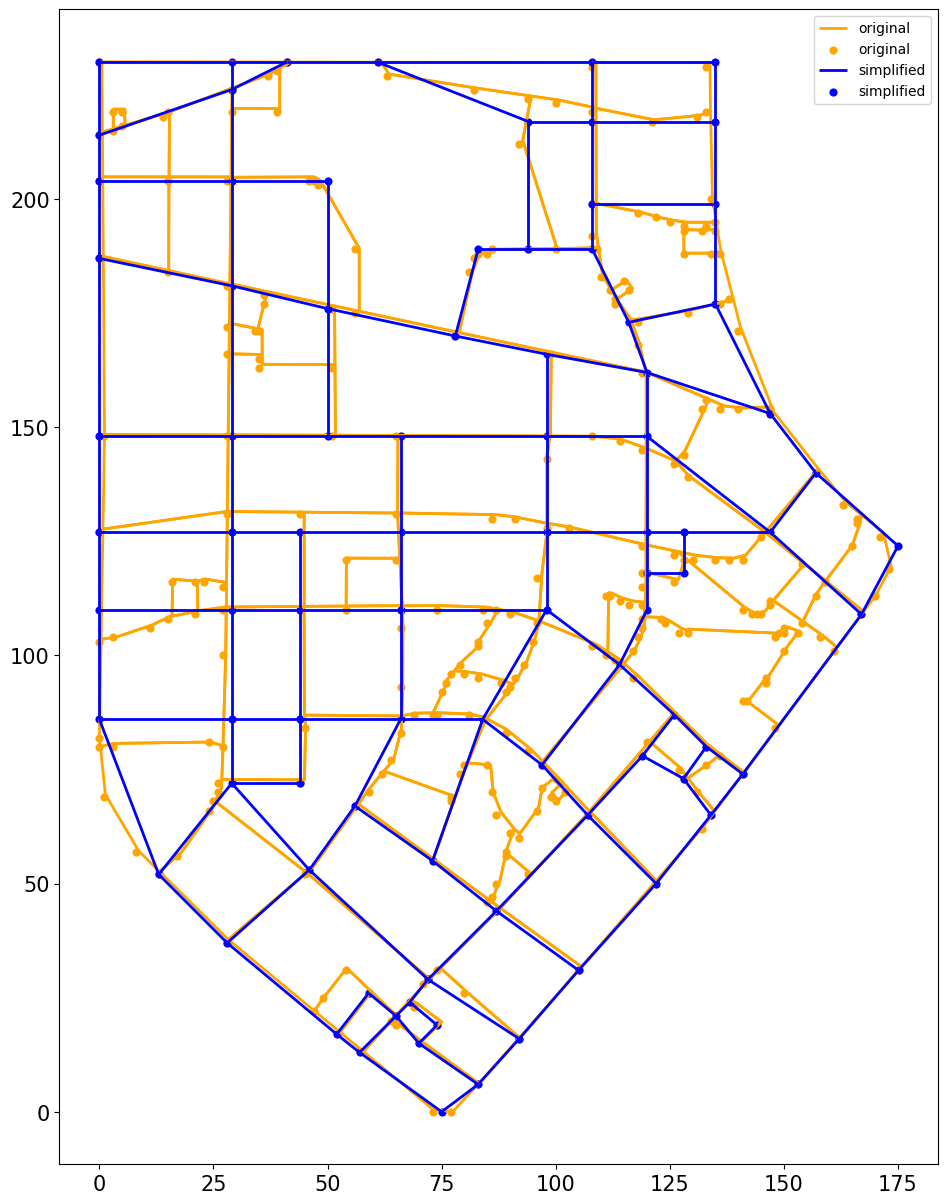

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
gdf_road_exploded.plot(ax=ax, linewidth=2, markersize=15, color='orange', label='original')
gdf_road_simplified.plot(ax=ax, linewidth=2, markersize=15, color='blue', label='simplified')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend()
plt.show()

## initial land use conditions

In [36]:
# gdf_simplified.explore()

In [15]:
#修改后的
gdf_simplified.explore()

In [16]:
# input land use
residential_ids = [60]
business_ids = []
school_ids = []
office_ids = []
green_l_ids = []
green_s_ids = [56]
hospital_l_ids = []
hospital_s_ids = []
outside_ids = []
gdf_simplified.loc[residential_ids, 'type'] = 4
gdf_simplified.loc[business_ids, 'type'] = 5
gdf_simplified.loc[school_ids, 'type'] = 9
gdf_simplified.loc[office_ids, 'type'] = 6
gdf_simplified.loc[green_l_ids, 'type'] = 7
gdf_simplified.loc[green_s_ids, 'type'] = 8
gdf_simplified.loc[outside_ids, 'type'] = 0
gdf_simplified.loc[hospital_l_ids, 'type'] = 10
gdf_simplified.loc[hospital_s_ids, 'type'] = 11

In [ ]:
# input land use 原始
residential_ids = [232, 233, 235, 236, 242, 256, 262, 265, 248, 263, 264, 272, 277, 276]
business_ids = [229]
school_ids = [281]
office_ids = []
green_l_ids = []
green_s_ids = [241, 243]
hospital_l_ids = [282]
hospital_s_ids = [239, 275, 270]
outside_ids = [271, 244]
gdf_simplified.loc[residential_ids, 'type'] = 4
gdf_simplified.loc[business_ids, 'type'] = 5
gdf_simplified.loc[school_ids, 'type'] = 9
gdf_simplified.loc[office_ids, 'type'] = 6
gdf_simplified.loc[green_l_ids, 'type'] = 7
gdf_simplified.loc[green_s_ids, 'type'] = 8
gdf_simplified.loc[outside_ids, 'type'] = 0
gdf_simplified.loc[hospital_l_ids, 'type'] = 10
gdf_simplified.loc[hospital_s_ids, 'type'] = 11

In [17]:
print(gdf_simplified.area.sum())
print(gdf_simplified.unary_union.bounds)

60579.5
(0.0, 0.0, 456.0, 280.0)


## visualize

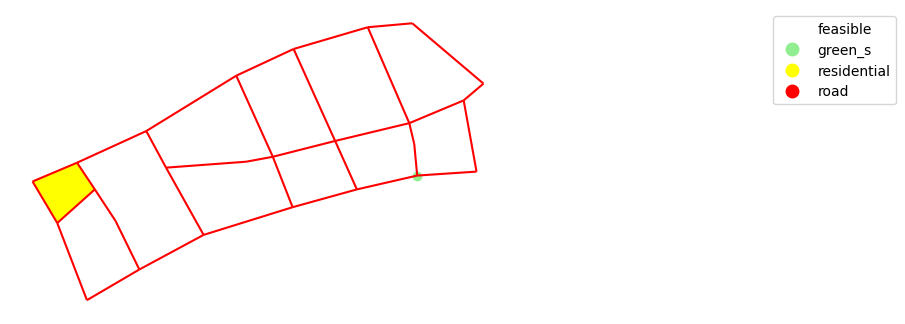

In [18]:
TYPE_COLOR_MAP = {
    'boundary': 'lightgreen',
    'business': 'fuchsia',
    'feasible': 'white',
    'green_l': 'green',
    'green_s': 'lightgreen',
    'hospital_l': 'blue',
    'hospital_s': 'cyan',
    'office': 'gold',
    'outside': 'black',
    'residential': 'yellow',
    'road': 'red',
    'school': 'darkorange',
    'recreation': 'lavender'
}

gdf_viz = copy.deepcopy(gdf_simplified[(gdf_simplified['existence'] == True) &
                                          (gdf_simplified['type'] != OUTSIDE) &
                                          (gdf_simplified['type'] != BOUNDARY) &
                                          (gdf_simplified['type'] != INTERSECTION)])
gdf_viz['legend'] = gdf_viz['type'].apply(lambda x: LAND_USE_ID_MAP_INV[x])
#gdf_viz = gdf_viz[gdf_viz.geom_type=='Polygon']
existing_types = sorted([LAND_USE_ID_MAP_INV[var] for var in gdf_viz['type'].unique()])
cmap = ListedColormap(
    [TYPE_COLOR_MAP[var] for var in existing_types])
gdf_viz.plot(
    'legend',
    cmap=cmap,
    categorical=True,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.8, 1)}
)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [19]:
d = dict()
d['gdf'] = gdf_simplified
with open('./init_plan_jh.pickle', 'wb') as f:
    pickle.dump(d, f)